# Lab 6 Report: 
## Text Classification on AG News Dataset

In [1]:
import torch
import time
import numpy as np
import seaborn as sns


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/liambakar/anaconda3/envs/ee596/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/liambakar/anaconda3/envs/ee596/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/liambakar/anaconda3/envs/ee596/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

In [2]:
from IPython.display import Image # For displaying images in colab jupyter cell

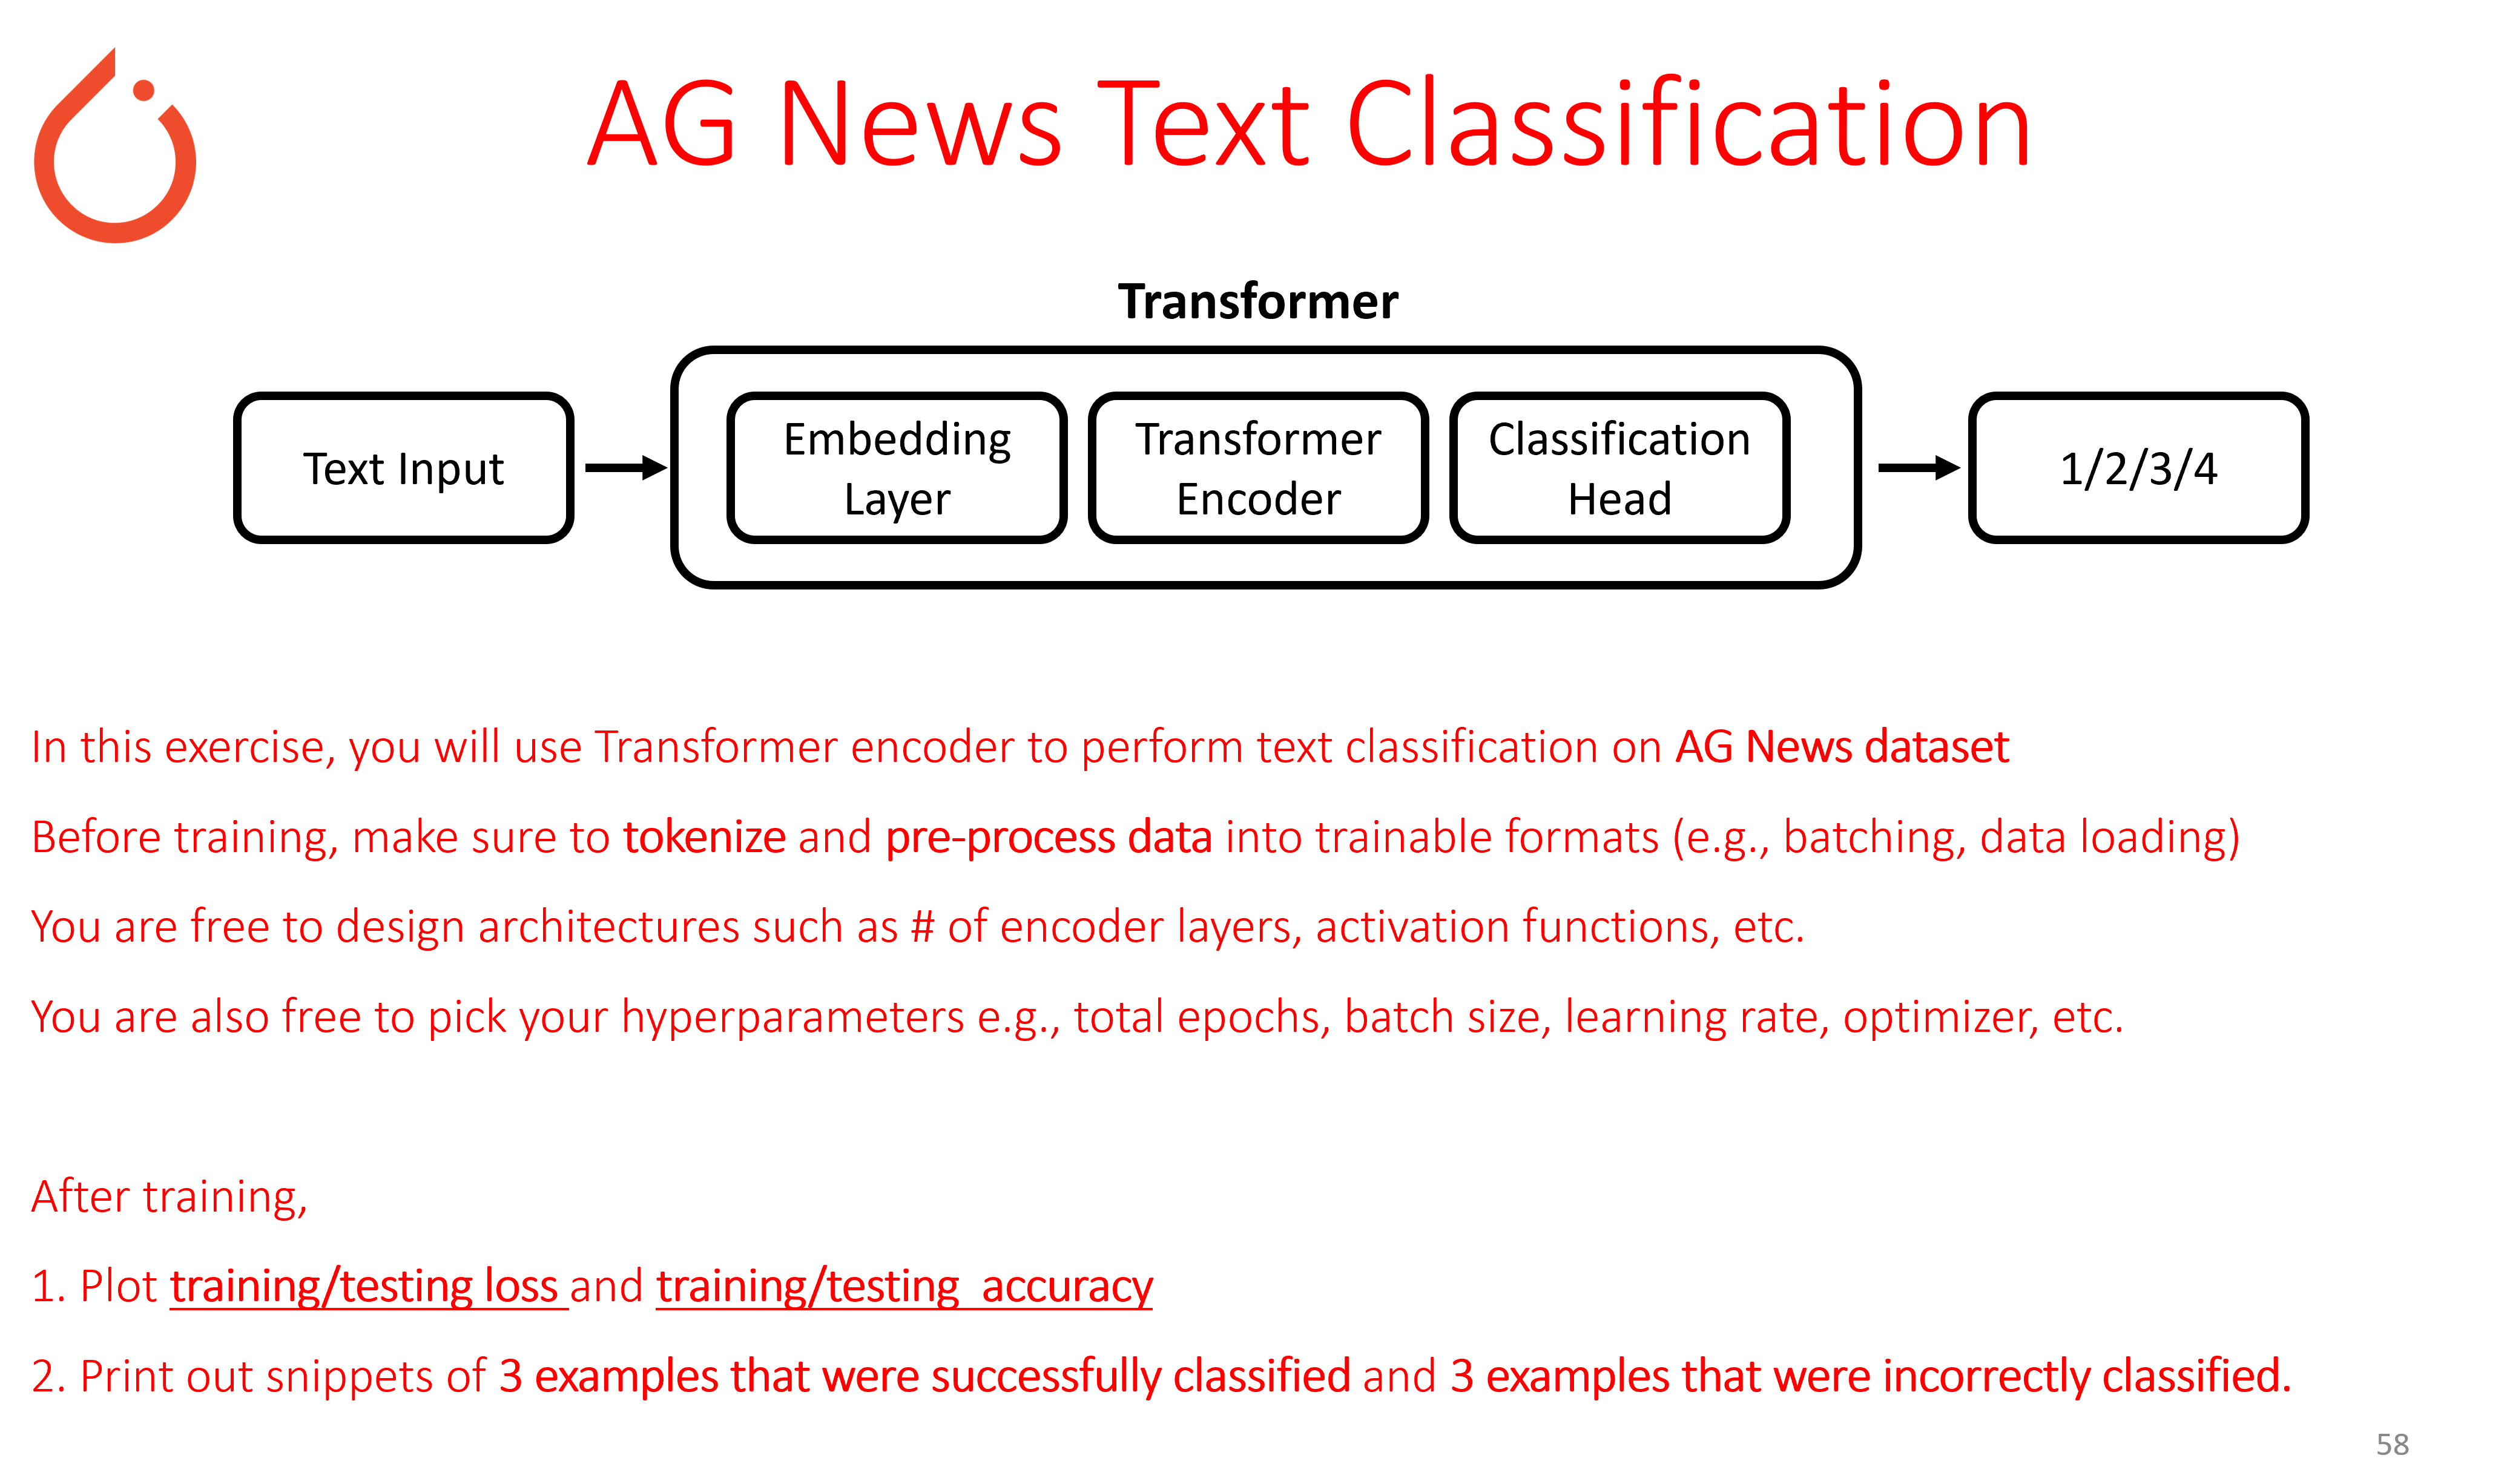

In [3]:
Image('lab6_exercise.png', width = 1000)

## Prepare Data

In [19]:
import torchtext
from torch.utils.data import DataLoader
from collections import Counter
import pandas as pd

# 40, 6 head

# Load dataset and initialize tokenizer

# train_iter, test_iter = torchtext.datasets.AG_NEWS(root='datasets', split=('train', 'test'))
test_path = 'datasets/AG_NEWS/test.csv'
train_path = 'datasets/AG_NEWS/train.csv'

train_df = pd.read_csv(train_path, header=None)
train_df.columns = ['label', 'title', 'samples']
test_df = pd.read_csv(test_path, header=None)
test_df.columns = ['label', 'title', 'samples']
# train_iter = train_df.values.tolist()
# test_iter = test_df.values.tolist()


label_counts = Counter()
for label, _, __ in train_df.values.tolist():
    label_counts[label] += 1
print("Label distribution in train_iter:", label_counts)


label_counts = Counter()
for label, _, __ in test_df.values.tolist():
    label_counts[label] += 1
print("Label distribution in test_iter:", label_counts)

Label distribution in train_iter: Counter({3: 30000, 4: 30000, 2: 30000, 1: 30000})
Label distribution in test_iter: Counter({3: 1900, 4: 1900, 2: 1900, 1: 1900})


In [21]:
# Tokenize the data

# YOUR CODE HERE
# Reload train_iter for use in DataLoader
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for _, __, text in data_iter:
        yield tokenizer(text)

# Create vocabulary with special tokens for padding and unknown words
vocab = torchtext.vocab.build_vocab_from_iterator(yield_tokens(train_df.values.tolist()), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])

In [23]:
def text_pipeline(x): 
    return vocab(tokenizer(x))
    
# Example: Test the pipeline on a sample text
sample_text = "This is a sample text of a Science article."
print(text_pipeline(sample_text))

[48, 23, 5, 6231, 3962, 7, 5, 1384, 3548, 2]


100%|██████████| 7600/7600 [00:00<00:00, 85426.91it/s]


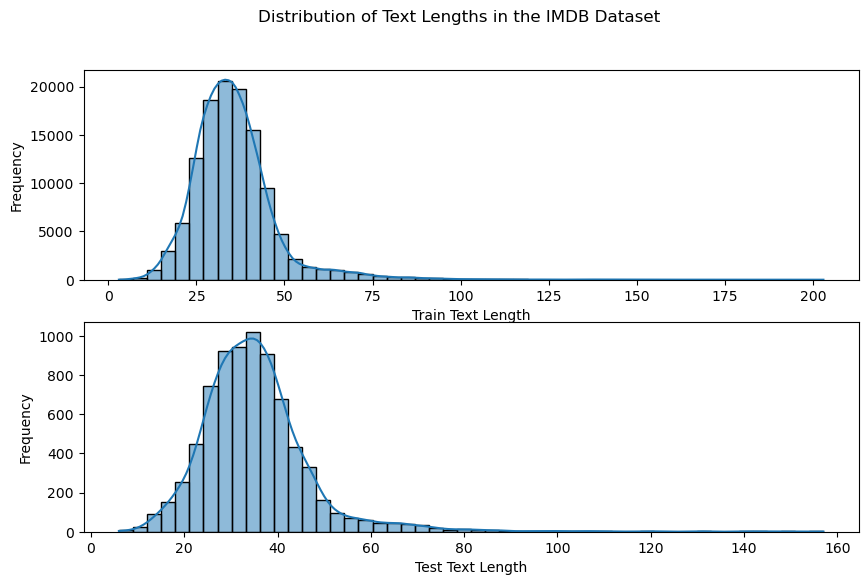

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Function to calculate the length of each text in the dataset
def get_text_lengths(data_iter):
    lengths = []
    for _, __, text in tqdm(data_iter):
        tokenized_text = tokenizer(text)
        lengths.append(len(tokenized_text))
    return np.array(lengths)

# Load IMDB train dataset
train_iter, test_iter = train_df.values.tolist(), test_df.values.tolist()

# Get text lengths from the entire dataset
train_text_lengths = get_text_lengths(train_iter)
test_text_lengths = get_text_lengths(test_iter)
# Plot the distribution of text lengths

# Define bin edges using the range of both datasets
min_bin = min(train_text_lengths.min(), test_text_lengths.min())
max_bin = max(train_text_lengths.max(), test_text_lengths.max())
bins = np.linspace(min_bin, max_bin, 30)  # Adjust number of bins as needed

plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
sns.histplot(train_text_lengths, kde=True, bins=50)
plt.xlabel('Train Text Length')
plt.ylabel('Frequency')
plt.subplot(2,1,2)
sns.histplot(test_text_lengths, kde=True, bins=50)
plt.xlabel('Test Text Length')
plt.ylabel('Frequency')
plt.suptitle('Distribution of Text Lengths in the IMDB Dataset')
plt.show()

In [26]:
from torch.nn.utils.rnn import pad_sequence

# Define collate function for padding and batching
# setting a max_seq_len helps with estimating the max gpu memory usage
def collate_batch(batch, max_seq_len=1024):
    labels, titles, texts = zip(*batch)
    # the labels start at 1 but predictions start at 0. To align them, we modify lables
    labels = torch.tensor(labels,dtype=torch.long)-1
    
    text_list = []
    for text in texts:
        # Truncate or pad to max_seq_len
        tokenized_text = text_pipeline(text)
        if len(tokenized_text) > max_seq_len:
            tokenized_text = tokenized_text[:max_seq_len]  # Truncate if longer than max_seq_len
        else:
            # Pad if shorter than max_seq_len
            tokenized_text = tokenized_text + [vocab["<pad>"]] * (max_seq_len - len(tokenized_text))
        
        text_list.append(torch.tensor(tokenized_text, dtype=torch.long))
    
    padded_texts = torch.stack(text_list)  # Stack the sequences into a tensor
    return padded_texts, labels

In [27]:
# YOUR CODE HERE
from torch.utils.data import Dataset

class AGNewsDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label, title, text = self.data[idx]
        return label, title, text
# Create datasets
train_dataset = AGNewsDataset(train_df.values.tolist())
test_dataset = AGNewsDataset(test_df.values.tolist())

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

## Define Model

In [29]:
from torch import nn
class TransformerModel(torch.nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, num_encoder_layers, num_classes, dropout=0.1):
        
        super(TransformerModel, self).__init__()
        
        self.embedding = torch.nn.Embedding(vocab_size, embed_size)
        self.transformer = torch.nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embed_size, num_heads, embed_size * 2, dropout),
            num_encoder_layers
        )
        self.fc = torch.nn.Linear(embed_size, num_classes)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)  # Embedding layer
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, embedding_size)
        x = self.transformer(x)  # Apply transformer
        x = x.mean(dim=0)  # Pooling (take the mean of all tokens in the sequence)
        x = self.dropout(x)
        x = self.fc(x)  # Final classification layer
        return x

## Define Hyperparameters

In [31]:
# Check for device compatibility, prioritizing CUDA, then MPS for MacBooks with Apple Silicon, and defaulting to CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# Initialize the model, 
embed_size = 42
num_heads = 6
num_encoder_layers = 2
num_classes = 4
model = TransformerModel(
    vocab_size=len(vocab),
    embed_size=embed_size,
    num_heads=num_heads,
    num_encoder_layers=num_encoder_layers,
    num_classes=num_classes
)

# Initialize loss function, and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.to(device)

Using device: mps


/Users/liambakar/anaconda3/envs/ee596/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerModel(
  (embedding): Embedding(88162, 42)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=42, out_features=42, bias=True)
        )
        (linear1): Linear(in_features=42, out_features=84, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=84, out_features=42, bias=True)
        (norm1): LayerNorm((42,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((42,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=42, out_features=4, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

## Identify Tracked values

In [32]:
# YOUR CODE HERE
num_epochs = 5
train_losses = np.zeros(num_epochs)
train_accuracies = np.zeros(num_epochs)

test_losses = np.zeros(num_epochs)
test_accuracies = np.zeros(num_epochs)

## Train Model

In [33]:
# YOUR CODE HERE
def train_epoch(model, train_loader, loss_fn, optimizer):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    # total_batches = 0
    total_batches = len(train_loader)
    
    for texts, labels in tqdm(train_loader):
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(texts)
        
        # Compute loss and gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        # Calculate accuracy
        preds = torch.argmax(outputs, dim=1)
        correct = (preds == labels).sum().item()
        accuracy = correct / labels.size(0)
        
        epoch_loss += loss.item()
        epoch_accuracy += accuracy
    
    return epoch_loss / total_batches, epoch_accuracy / total_batches

def evaluate(model, test_loader, loss_fn):
    model.eval()
    epoch_loss = 0
    epoch_accuracy = 0
    total_batches = len(test_loader)
    
    with torch.no_grad():
        for texts, labels in tqdm(test_loader):
            texts, labels = texts.to(device), labels.to(device)
            # Forward pass
            outputs = model(texts)
            
            # Compute loss
            loss = loss_fn(outputs, labels)
            
            # Calculate accuracy
            preds = torch.argmax(outputs, dim=1)
            correct = (preds == labels).sum().item()
            accuracy = correct / labels.size(0)
            
            epoch_loss += loss.item()
            epoch_accuracy += accuracy
    
    return epoch_loss / total_batches, epoch_accuracy / total_batches

In [34]:
for epoch in range(num_epochs):
    start_time = time.time()
    
    # Train for one epoch
    train_loss, train_accuracy = train_epoch(model, train_loader, loss_fn, optimizer)
    train_losses[epoch] = train_loss
    train_accuracies[epoch] = train_accuracy
    
    # Evaluate on the test set
    test_loss, test_accuracy = evaluate(model, test_loader, loss_fn)
    test_losses[epoch] = test_loss
    test_accuracies[epoch] = test_accuracy
    end_time = time.time()
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Time: {end_time - start_time:.2f}s")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

100%|██████████| 238/238 [00:20<00:00, 11.60it/s]


Epoch [1/5] | Time: 2638.70s
Train Loss: 0.5249 | Train Accuracy: 0.8012
Test Loss: 0.3649 | Test Accuracy: 0.8721


100%|██████████| 238/238 [00:20<00:00, 11.84it/s]


Epoch [2/5] | Time: 2552.71s
Train Loss: 0.3102 | Train Accuracy: 0.8936
Test Loss: 0.3316 | Test Accuracy: 0.8872


100%|██████████| 238/238 [00:20<00:00, 11.72it/s]


Epoch [3/5] | Time: 2432.51s
Train Loss: 0.2473 | Train Accuracy: 0.9153
Test Loss: 0.2921 | Test Accuracy: 0.8998


100%|██████████| 238/238 [00:19<00:00, 12.07it/s]


Epoch [4/5] | Time: 2916.19s
Train Loss: 0.2033 | Train Accuracy: 0.9305
Test Loss: 0.3094 | Test Accuracy: 0.8992


100%|██████████| 238/238 [00:19<00:00, 12.06it/s]

Epoch [5/5] | Time: 2794.22s
Train Loss: 0.1686 | Train Accuracy: 0.9430
Test Loss: 0.3262 | Test Accuracy: 0.9023


## Visualize and Evaluate Model

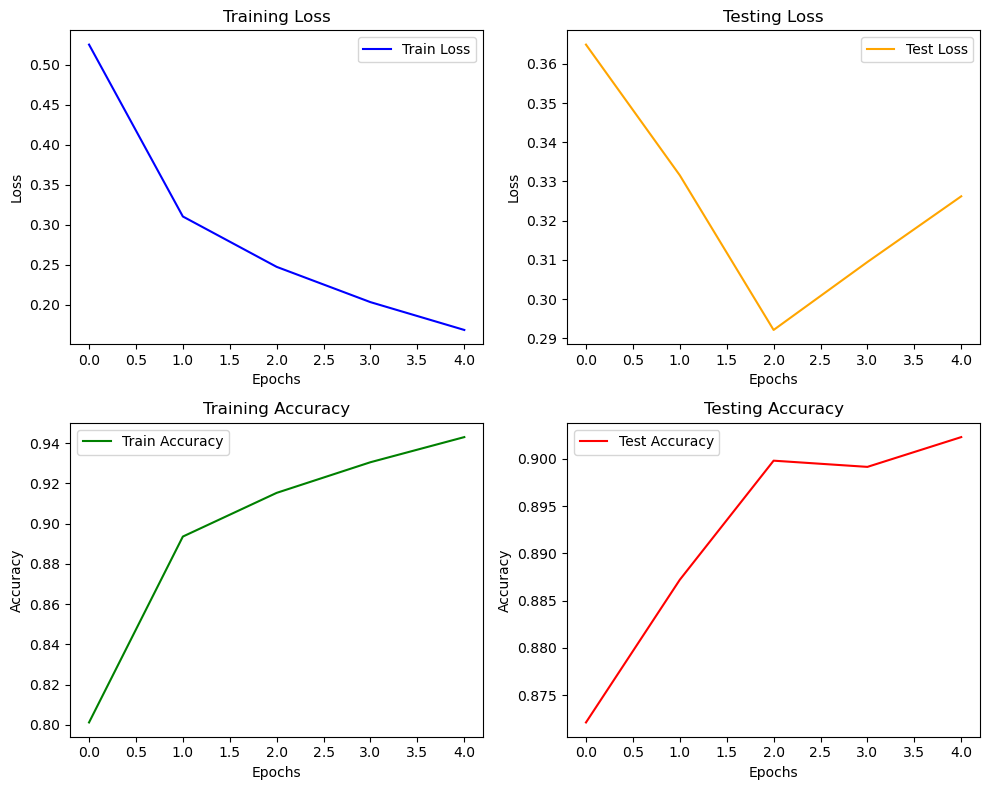

In [35]:
# YOUR CODE HERE
num_epochs = 5
epochs = list(range(0, num_epochs))

# Create 2x2 grid of subplots using plt.subplot
plt.figure(figsize=(10, 8))

# Training Loss
plt.subplot(2, 2, 1)  # (rows, columns, index)
plt.plot(epochs, train_losses, color='blue', label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Testing Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, test_losses, color='orange', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, train_accuracies, color='green', label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Testing Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, test_accuracies, color='red', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [38]:
# Print out 3 examples of correctly classified samples and 3 examples of incorrectly classified samples from testing data

# YOUR CODE HERE
def print_classification_examples(model, test_loader, num_examples=3):
    model.eval()
    correct_examples = []
    incorrect_examples = []
    
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            preds = torch.argmax(outputs, dim=1)
            
            for i in range(len(labels)):
                if len(correct_examples) < num_examples and preds[i] == labels[i]:
                    correct_examples.append((texts[i], labels[i], preds[i]))
                elif len(incorrect_examples) < num_examples and preds[i] != labels[i]:
                    incorrect_examples.append((texts[i], labels[i], preds[i]))
                
                if len(correct_examples) >= num_examples and len(incorrect_examples) >= num_examples:
                    break
            
            if len(correct_examples) >= num_examples and len(incorrect_examples) >= num_examples:
                break
    
    return correct_examples, incorrect_examples

def decode_text(text_tensor):
    return " ".join([vocab.lookup_token(token.item()) for token in text_tensor if token.item() != vocab["<pad>"]])

def print_examples(examples, title):
    print(title)
    classes = ['World', 'Sports', 'Business', 'Science/Technology']
    for i, (text_tensor, label, pred) in enumerate(examples):
        text = decode_text(text_tensor)
        print(f"Example {i+1}:")
        print(f"Text: {text}")
        print(f"True Label: {classes[label.item()]}") 
        print(f"Predicted Label: {classes[pred.item()]}") 
        print("-" * 50)


In [39]:
correct_examples, incorrect_examples = print_classification_examples(model, test_loader)

print_examples(correct_examples, "Correctly Classified Samples:")
print_examples(incorrect_examples, "Incorrectly Classified Samples:")

Correctly Classified Samples:
Example 1:
Text: space . com - toronto , canada -- a <unk> of rocketeers competing for the #36 10 million ansari x prize , a contest <unk> funded suborbital space flight , has officially announced the <unk> date for its manned rocket .
True Label: Science/Technology
Predicted Label: Science/Technology
--------------------------------------------------
Example 2:
Text: ap - a company founded by a chemistry researcher at the university of louisville won a grant to develop a method of producing better peptides , which are short chains of amino acids , the building blocks of proteins .
True Label: Science/Technology
Predicted Label: Science/Technology
--------------------------------------------------
Example 3:
Text: ap - southern california ' s <unk> agency went after emissions of the bovine variety friday , adopting the nation ' s first rules to reduce air pollution from dairy cow manure .
True Label: Science/Technology
Predicted Label: Science/Technology
-